## Project

First the imports

In [1]:
import scipy.io as sio
import numpy as np
from scipy.optimize import nnls, minimize
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import multivariate_normal, norm
from numpy import matlib
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold

Below is the image under study

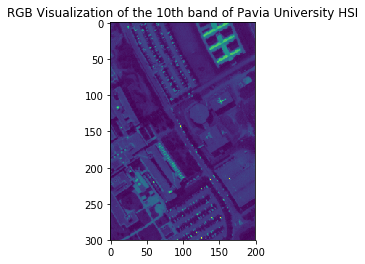

In [2]:
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()

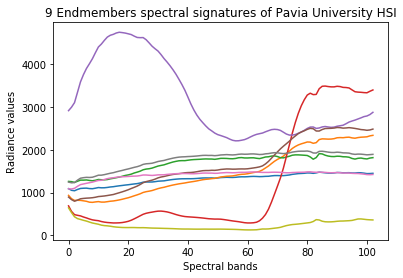

In [3]:
ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']

fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

In [4]:
#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth = sio.loadmat('PaviaU_ground_truth.mat')
labels = ground_truth['y']

### Part 1

General purpose functions to be used for abundance maps and reconstruction errors.

In [5]:
#(i)abudance maps
def abudance_maps(theta, m, n):
    fig = plt.figure(figsize=(2 * 1.8 * 9, 2 * 2.4 * 9))
    for j in range(9):
        plt.subplot(1, 9, j+1)
        plt.imshow(theta[:,j].reshape((m,n)))
        plt.title('Endmember %d'%(j+1))
            
#(ii)reconstruction error
def MSE(y, y_est, mxn):
    MSE_error = np.empty((0))
    
    for i in range(mxn):
        if label[i]!=0:
            error = np.linalg.norm(y[i,:] - y_est[i,:])**2
            MSE_error = np.append(MSE_error, [error])

    mean_error = np.mean(MSE_error)
    return mean_error

Variables used in Part 1

In [6]:
#dimensions of HSI image
[M, N, L] = HSI.shape
MxN = M*N

#reshape cubes to 2d matrices for easier calculations
y = HSI.reshape((MxN,L))
label = labels.reshape((MxN,1))
X = endmembers

#### (a) Least Squares

In [7]:
## The function below gets as input a matrix X and a vector y.
## The output is a vector theta, calculated using the MSE criterion

#function for theta calculation
def theta_calc(X, y):
    #transpose matrix
    XT = X.transpose()

    #X transpose multiplied by X
    XTX = XT.dot(X)

    #inverse of XTX+lI
    invXTX = inv(XTX)

    #theta estimation
    theta_estimated = (invXTX.dot(XT)).dot(y)
    
    return theta_estimated

In [8]:
#theta calculation for each pixel using MSE criterion
#calculations only for nonzero labels

#initialize theta matrix
theta_matrix_ls = np.zeros((MxN,9))

for i in range(MxN):
    if label[i]!=0:
        theta_matrix_ls[i] = theta_calc(X, y[i])     

(i) Abundance maps: The maps that show the participation of each endmember to the final image

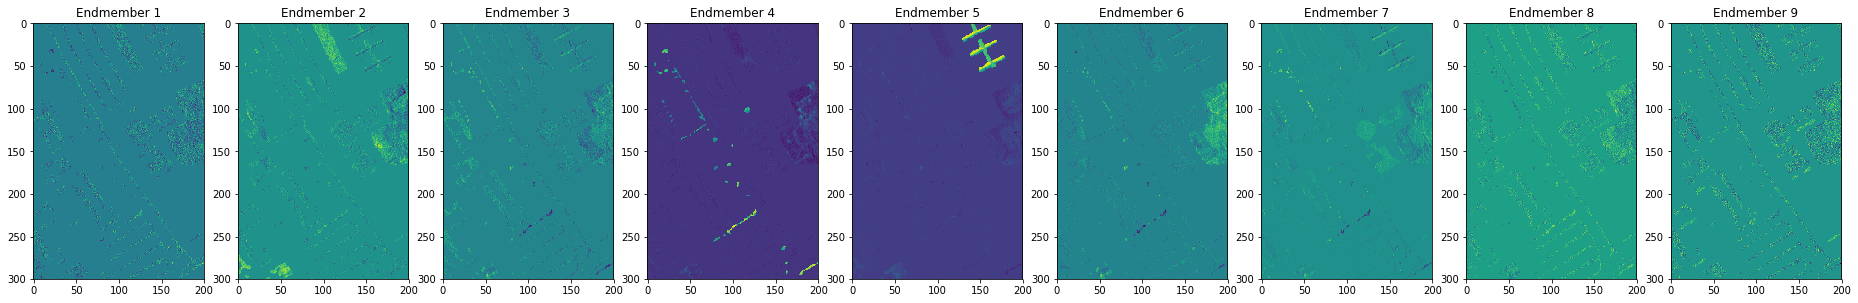

In [9]:
abudance_maps(theta_matrix_ls, M, N)

(ii) Reconstruction error

In [10]:
#calculate reconstruction error
y_reconstructed = X.dot(theta_matrix_ls.T)

mse_ls = MSE(y, y_reconstructed.T, MxN)
print("MSE = %.2f"%(mse_ls))

MSE = 118783.18


#### (b) Least Squares - sum-to-one

In [11]:
#initialize theta matrix
theta_matrix_ls1 = np.zeros((MxN,9))
#find a dummy solution
th0 = nnls(X, y[0])[0]

In [12]:
#Define minimization function
def min_f(x, th, y):
    return np.linalg.norm(th.dot(x) - y)

In [13]:
#Constraints function: sum(theta)==1,
c = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1})
    
for i in range(MxN):
    if label[i]!=0:
        theta_matrix_ls1[i] =  minimize(min_f, th0, args = (X, y[i]), method = 'SLSQP', constraints = c).x

(i) Abundance maps: The maps that show the participation of each endmember to the final image

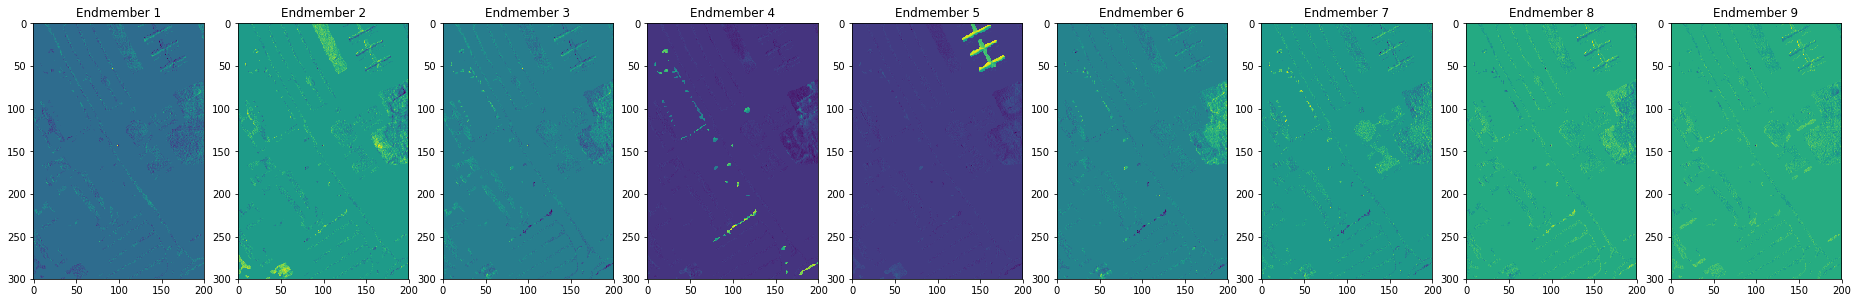

In [14]:
abudance_maps(theta_matrix_ls1, M, N)

(ii) Reconstruction error

In [15]:
#calculate reconstruction error
y_reconstructed = X.dot(theta_matrix_ls1.T)

mse_ls1 = MSE(y, y_reconstructed.T, MxN)
print("MSE = %.2f"%(mse_ls1))

MSE = 160049.93


#### (c) Least Squares - non-negativity

In [16]:
#initialize theta matrix
theta_matrix_nn = np.zeros((MxN,9))

for i in range(MxN):
    if label[i]!=0:
        theta_matrix_nn[i] = nnls(X, y[i,:])[0]

(i) Abundance maps: The maps that show the participation of each endmember to the final image

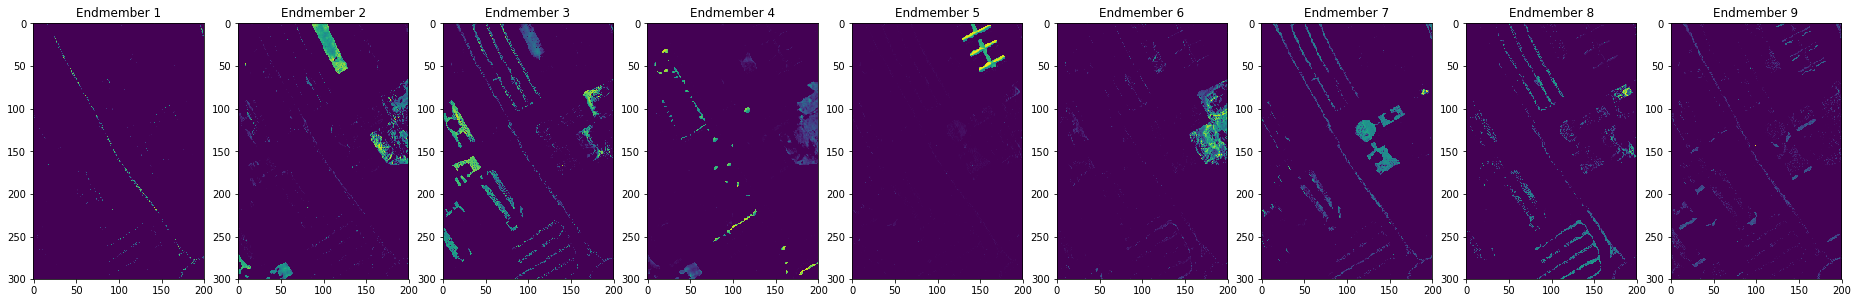

In [17]:
abudance_maps(theta_matrix_nn, M, N)

(ii) Reconstruction error

In [18]:
#calculate reconstruction error
y_reconstructed = X.dot(theta_matrix_nn.T)

mse_nn = MSE(y, y_reconstructed.T, MxN)
print("MSE = %.2f"%(mse_nn))

MSE = 569339.29


#### (d) Least Squares - non-negativity + sum-to-one

In [19]:
#bounds: non-negative
b = [(0., None) for x in th0]

In [20]:
#initialize theta matrix
theta_matrix_ls1_nn = np.zeros((MxN,9))

for i in range(MxN):
    if label[i]!=0:
        theta_matrix_ls1_nn[i] =  minimize(min_f, th0, args = (X, y[i]), method = 'SLSQP',
                                           constraints = c,
                                           bounds = b).x

(i) Abundance maps: The maps that show the participation of each endmember to the final image

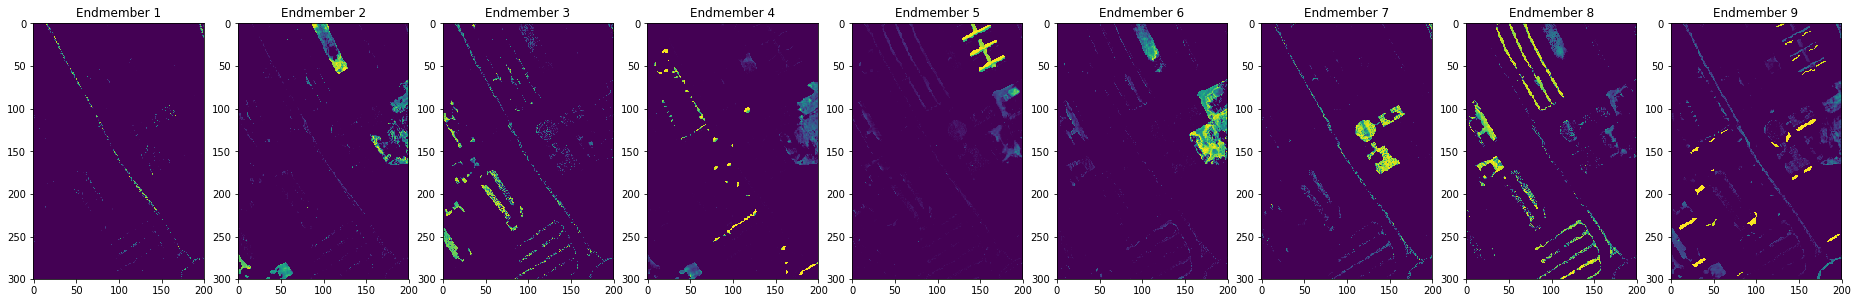

In [21]:
abudance_maps(theta_matrix_ls1_nn, M, N)

(ii) Reconstruction error

In [22]:
#calculate reconstruction error
y_reconstructed = X.dot(theta_matrix_ls1_nn.T)

mse_ls1_nn = MSE(y, y_reconstructed.T, MxN)
print("MSE = %.2f"%(mse_ls1_nn))

MSE = 4536454.54


#### (e) Least Squares - Lasso

In [23]:
#initialize theta matrix
theta_matrix_lasso = np.zeros((MxN,9))

for i in range(MxN):
    if label[i]!=0:
        clf = linear_model.Lasso(alpha = 0.1, fit_intercept = False, positive = True, max_iter = 10**8)
        clf.fit(X,y[i])
        theta_matrix_lasso[i] = clf.coef_

(i) Abundance maps: The maps that show the participation of each endmember to the final image

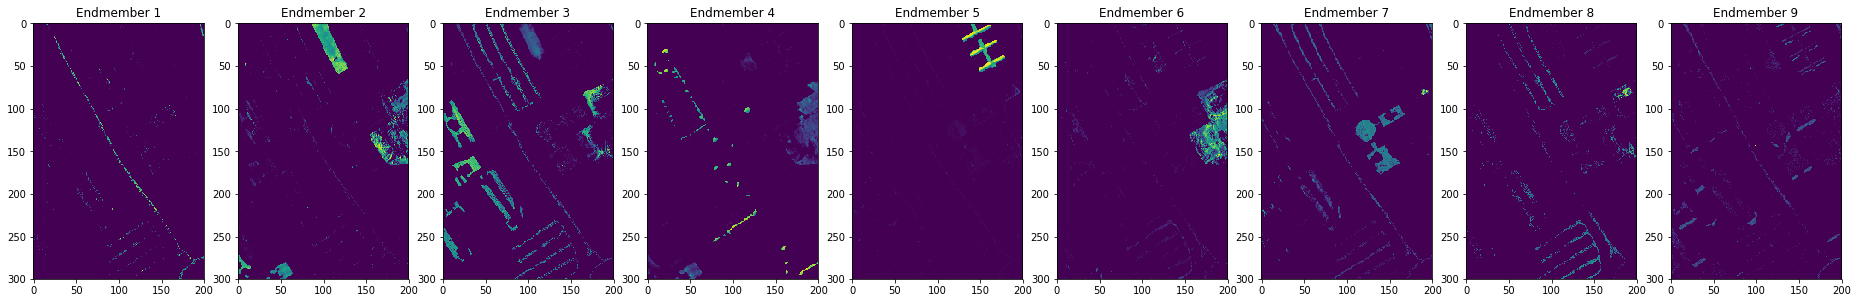

In [24]:
abudance_maps(theta_matrix_lasso, M, N)

(ii) Reconstruction error

In [25]:
#calculate reconstruction error
y_reconstructed = X.dot(theta_matrix_lasso.T)

mse_lasso = MSE(y, y_reconstructed.T, MxN)
print("MSE = %.2f"%(mse_lasso))

MSE = 570527.70


**Comparing the results**

In [26]:
print("Error of LS is %.2f"%(mse_ls))
print("Error of LS with sum-to-one constraint is %.2f"%(mse_ls1))
print("Error of LS with non-negativity constraint is %.2f"%(mse_nn))
print("Error of LS with both sum-to-one and non-negativity constraints is %.2f"%(mse_ls1_nn))
print("Error of LASSO is %.2f"%(mse_lasso))

Error of LS is 118783.18
Error of LS with sum-to-one constraint is 160049.93
Error of LS with non-negativity constraint is 569339.29
Error of LS with both sum-to-one and non-negativity constraints is 4536454.54
Error of LASSO is 570527.70


By the reconstruction errors, it seems that the Least Squares method is the best, since it has the smallest error value. Let's evaluate that by comparing the abundance maps:

These are the endmembers perfectly separated:

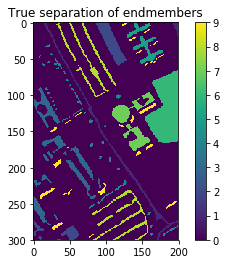

In [27]:
fig = plt.figure()
plt.imshow(labels)
plt.title('True separation of endmembers')
plt.colorbar()
plt.show()

These are the endmembers plotted each one in a different diagram:

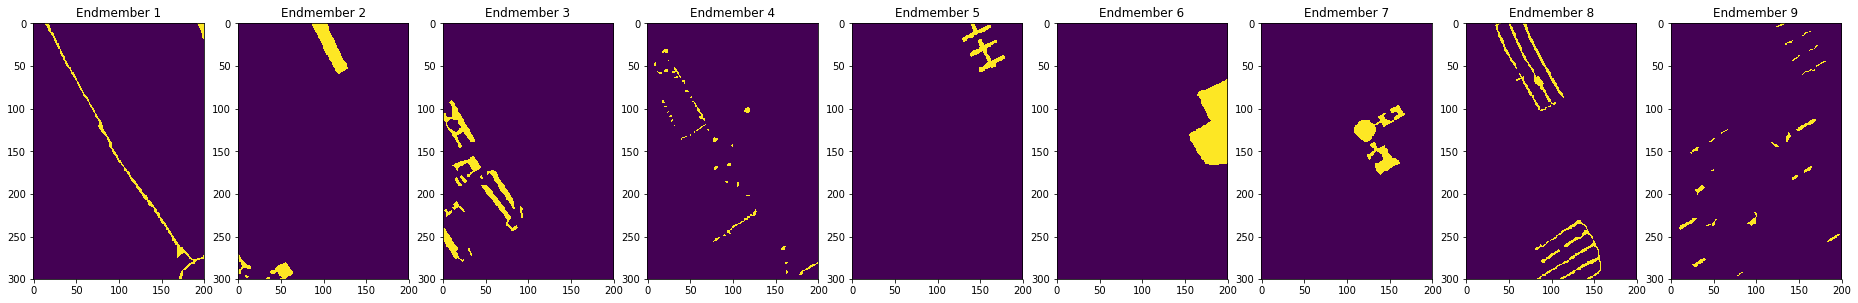

In [28]:
flag_array = np.empty((300, 200))
endmember_i = np.zeros((300, 200))
fig = plt.figure(figsize=(2 * 1.8 * 9, 2 * 2.4 * 9))

for i in range(1, 10):
    flag_array = (labels == i)
    endmember_i = flag_array.astype(int)
    plt.subplot(1, 9, i)
    plt.imshow(endmember_i)
    plt.title('Endmember %d'%(i))
plt.show()

Finally, these are the results of all the methods we used:

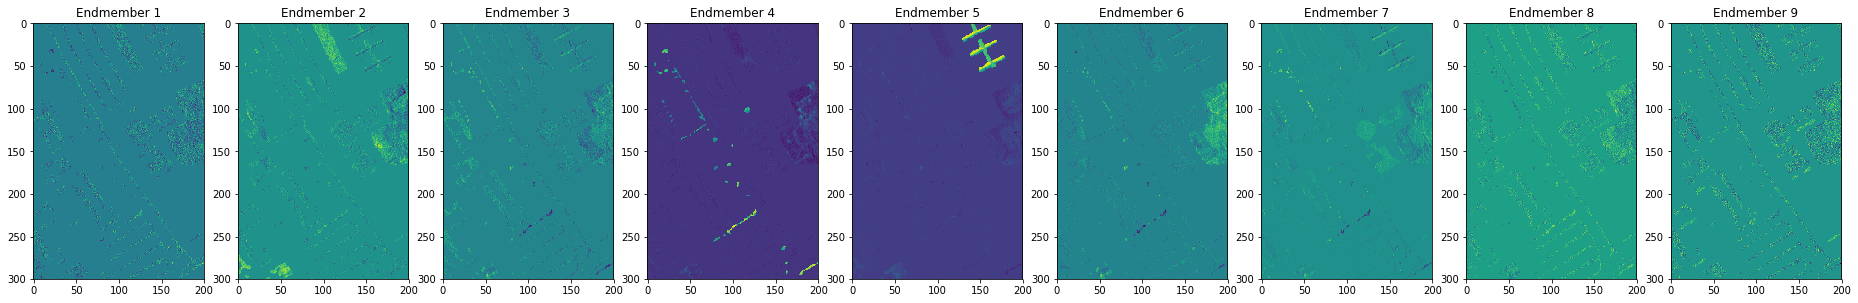

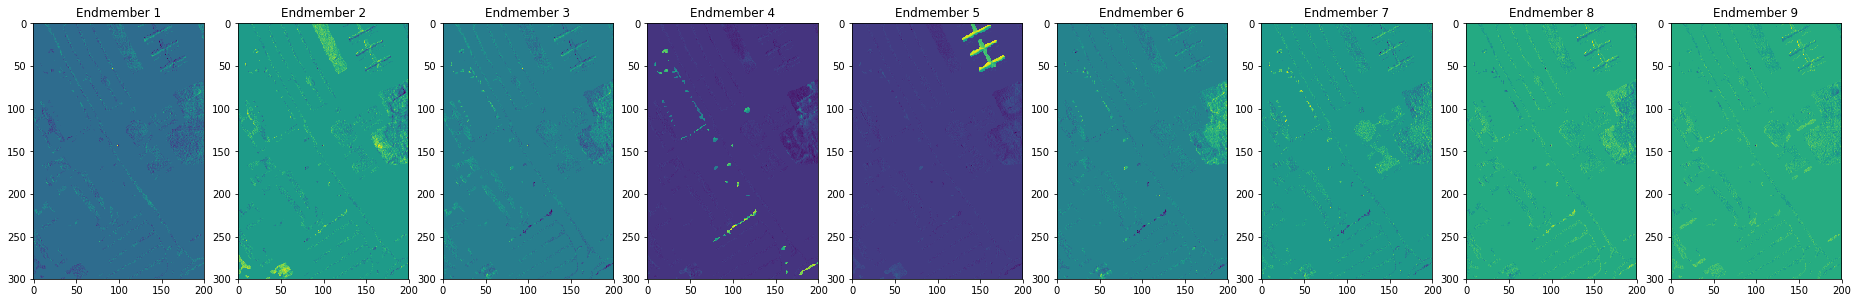

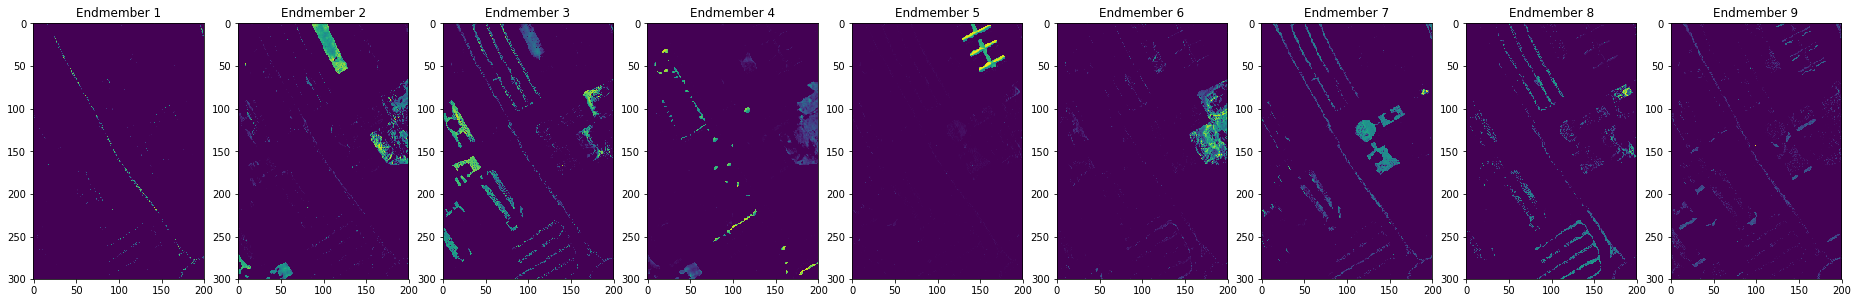

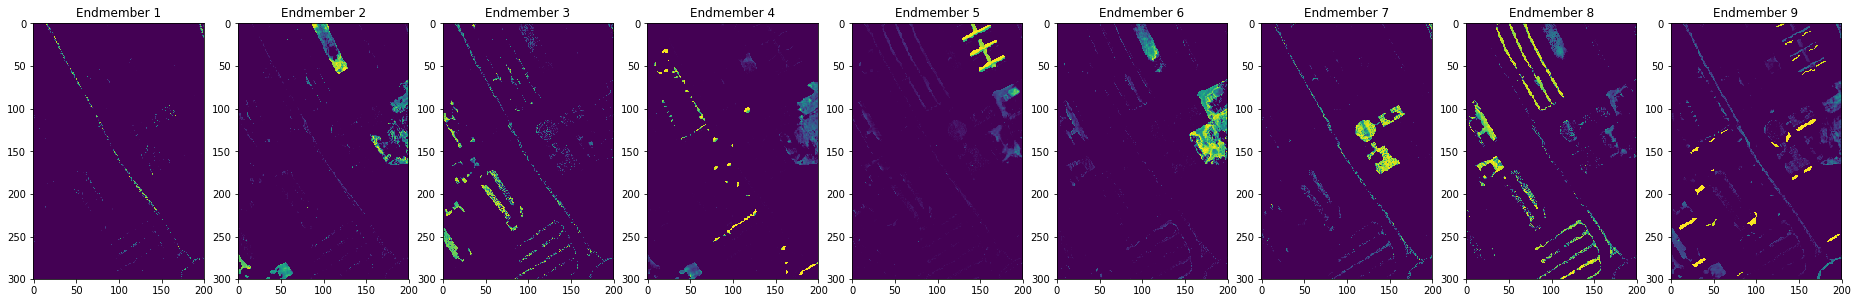

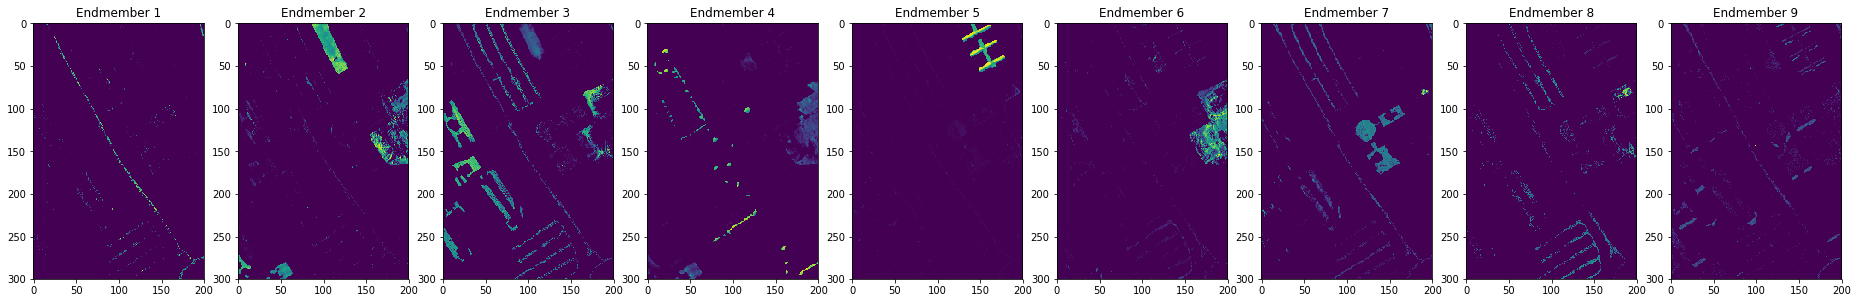

In [29]:
abudance_maps(theta_matrix_ls, M, N)
abudance_maps(theta_matrix_ls1, M, N)
abudance_maps(theta_matrix_nn, M, N)
abudance_maps(theta_matrix_ls1_nn, M, N)
abudance_maps(theta_matrix_lasso, M, N)

We can observe that the Least Squares method did not do as well as we may have thaught by looking at the errors. The same applies to the Least Squares method with sum-to-one constraint. The other three methods did better, with the Least Squares method with both sum-to-one and non-negativity constraint being the best.

### Part 2

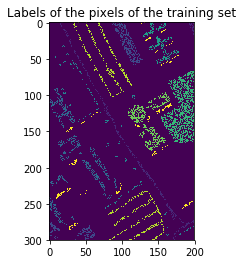

In [30]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

First, let's remove the class 0 frm the training and test sets. Also, sets are flattened for easier calculations.

In [31]:
Training_Set_flat = Training_Set.reshape((MxN,1))
Test_Set_flat = Test_Set.reshape((MxN,1))
Operational_Set_flat = Operational_Set.reshape((MxN,1))

X_train = np.empty((0,103))
y_train =  np.empty((0,1))
X_test = np.empty((0,103))
y_test =  np.empty((0,1))
X_op = np.empty((0,103))
y_op =  np.empty((0,1))

for i in range(MxN):
    if Training_Set_flat[i]!=0:
        X_train = np.append(X_train, [y[i,:]], axis = 0) 
        y_train = np.append(y_train, [Training_Set_flat[i]], axis = 0)

for i in range(MxN):
    if Test_Set_flat[i]!=0:
        X_test = np.append(X_test, [y[i,:]], axis = 0) 
        y_test = np.append(y_test, [Test_Set_flat[i]], axis = 0)

for i in range(MxN):
    if Operational_Set_flat[i]!=0:
        X_op = np.append(X_op, [y[i,:]], axis = 0) 
        y_op = np.append(y_op, [Operational_Set_flat[i]], axis = 0)

In [32]:
y_train = y_train.ravel()
y_test = y_test.ravel()
y_op = y_op.ravel()

#### (a) Naïve Bayes classifier

In [33]:
#Choose model. Run 10 times.
model = GaussianNB()
scores = cross_val_score(model, X_train, y_train, cv = 10)

In [34]:
#error is 1-score
errors = np.ones(10) - scores
NB_mean_error = np.mean(errors)
NB_std = np.std(errors)

print("Estimated validation error: %.5f"%(NB_mean_error))
print("Standard deviation of errors: %.5f"%(NB_std))

Estimated validation error: 0.35528
Standard deviation of errors: 0.05715


In [35]:
#train
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

cm_NB = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % cm_NB)

Confusion matrix:
[[131   0  37   0   0   0  80  13   0]
 [  0 326   4   6   0  17   0   0   0]
 [ 25   2 127   0   0  13  70 299   0]
 [  0   0   0 154   1   1   0   0   0]
 [  0   0   1   0 166   1   0   0   0]
 [  0 312   2  55  32 363   0   0   0]
 [ 18   0  26   0   0   0 277   0   0]
 [  2   1  67   0   0   1   2 388   0]
 [  0   0   0   2   0   0   0   0 185]]


In [36]:
sr_NB = np.trace(cm_NB)/np.sum(cm_NB)
print("Success rate of Naïve Bayes is %.4f"%(sr_NB))

Success rate of Naïve Bayes is 0.6601


In [37]:
#Operational Set
y_pred = model.predict(X_op)

cm_NB_op = confusion_matrix(y_op, y_pred)
print("Confusion matrix:\n%s" % cm_NB_op)

sr_NB_op = np.trace(cm_NB_op)/np.sum(cm_NB_op)
print("Success rate of Naïve Bayes is %.4f"%(sr_NB_op))

Confusion matrix:
[[154   0  46   1   0   0  57  14   0]
 [  0 304   3   6   0  13   0   0   0]
 [ 25   0 127   0   0  13  63 322   0]
 [  0   0   0 154   1   2   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0 333   5  51  35 342   0   0   0]
 [ 17   0  22   0   0   0 292   0   0]
 [ 10   8  82   0   1   0   5 339   0]
 [  0   0   0   1   0   0   0   0 188]]
Success rate of Naïve Bayes is 0.6458


#### (b) Minimum Euclidean distance classifier

Train based on 10-fold cross validation

In [38]:
kf = KFold(n_splits = 10)
errors_cv = np.empty((0,1))

for train_index, test_index in kf.split(X_train, y_train):
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_test_cv = X_train[test_index]
    y_test_cv = y_train[test_index]
    
    #mean calculation
    m_cv = []
    for i in range (9):
        indx = (y_train_cv==i+1).reshape(len(y_train_cv))
        m_cv.append(np.mean(X_train_cv[indx,:],0))
    
    #classification
    distance = []
    y_pred = []
    
    for i in range(len(X_test_cv)):
        for j in range(9):
            #calculate the 9 distanes
            distance.append(np.linalg.norm(X_test_cv[i] - m_cv[j])**2)
        #index of smallest index (+1) is the class that the pixel is assigned to
        y_pred.append(distance.index(np.min(distance))+1)
        distance = []
     
    a = confusion_matrix(y_test_cv, y_pred)
    errors_cv = np.append(errors_cv, 1-(np.trace(a)/np.sum(a)))

In [39]:
E_mean_error = np.mean(errors_cv)
E_std = np.std(errors_cv)

print("Estimated validation error: %.5f"%(E_mean_error))
print("Standard deviation of errors: %.5f"%(E_std))

Estimated validation error: 0.46533
Standard deviation of errors: 0.10535


Check performance on Test set

In [40]:
#means of classes
m = []
for i in range (9):
    indx = (y_train==i+1).reshape(len(y_train))
    m.append(np.mean(X_train[indx,:],0))

In [41]:
#predict
distance = []
y_pred = []

for i in range(len(X_test)):
    for j in range(9):
        distance.append(np.linalg.norm(X_test[i] - m[j])**2)
    y_pred.append(distance.index(np.min(distance))+1)
    distance = []

In [42]:
cm_E = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % cm_E)

Confusion matrix:
[[152   0  46   0   0   0  61   2   0]
 [  1 188   0   5   0 156   0   3   0]
 [ 66   2 198   0   0   1  39 230   0]
 [  0   0   0 154   0   0   0   0   2]
 [  0   0   0   0 128   0   0  40   0]
 [ 11 317   0  12  16 240   0 168   0]
 [ 61   0  23   0   0   0 237   0   0]
 [  2   1 145   0   0   1   7 305   0]
 [  0   0   0   0   0   0   0   0 187]]


In [43]:
sr_E = np.trace(cm_E)/np.sum(cm_E)
print("Success rate of Euclidean classifier is %.4f"%(sr_E))

Success rate of Euclidean classifier is 0.5578


In [44]:
#Operational Set
#predict
distance = []
y_pred = []

for i in range(len(X_op)):
    for j in range(9):
        distance.append(np.linalg.norm(X_op[i] - m[j])**2)
    y_pred.append(distance.index(np.min(distance))+1)
    distance = []

cm_E_op = confusion_matrix(y_op, y_pred)
print("Confusion matrix:\n%s" % cm_E_op)

sr_E_op = np.trace(cm_E_op)/np.sum(cm_E_op)
print("Success rate of Euclidean classifier is %.4f"%(sr_E_op))

Confusion matrix:
[[177   0  49   0   0   0  44   2   0]
 [  2 183   0   4   0 135   0   2   0]
 [ 61   0 206   0   0   0  38 245   0]
 [  0   0   0 155   0   1   0   0   1]
 [  0   0   0   0 143   0   0  28   0]
 [  9 339   3   9  14 210   0 182   0]
 [ 62   0  18   0   0   0 251   0   0]
 [  5  11 149   0   0   0  13 267   0]
 [  0   0   0   0   0   0   0   0 189]]
Success rate of Euclidean classifier is 0.5553


#### (c) k-nearest neighbor classifier

In [45]:
#Choose model. Run 10 times.
model = KNeighborsClassifier(n_neighbors = 3)
scores = cross_val_score(model, X_train, y_train, cv = 10)

In [46]:
#error is 1-score
errors = np.ones(10) - scores
KNN_mean_error = np.mean(errors)
KNN_std = np.std(errors)

print("Estimated validation error: %.5f"%(KNN_mean_error))
print("Standard deviation of errors: %.5f"%(KNN_std))

Estimated validation error: 0.15013
Standard deviation of errors: 0.05117


In [47]:
#train
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

cm_KNN = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % cm_KNN)

Confusion matrix:
[[203   0  15   0   0   0  20  23   0]
 [  0 325   0   0   0  28   0   0   0]
 [ 11   0 437   0   0   3   1  84   0]
 [  0   0   0 155   0   1   0   0   0]
 [  0   0   1   0 166   0   0   1   0]
 [  0  52   2   0   1 708   0   1   0]
 [ 15   0   5   0   0   0 301   0   0]
 [ 16   2  80   0   0   0   2 361   0]
 [  0   0   0   0   0   0   0   0 187]]


In [48]:
sr_KNN = np.trace(cm_KNN)/np.sum(cm_KNN)
print("Success rate of K-NN is %.4f"%(sr_KNN))

Success rate of K-NN is 0.8865


In [49]:
#Operational Set
y_pred = model.predict(X_op)

cm_KNN_op = confusion_matrix(y_op, y_pred)
print("Confusion matrix:\n%s" % cm_KNN_op)

sr_KNN_op = np.trace(cm_KNN_op)/np.sum(cm_KNN_op)
print("Success rate of Naïve Bayes is %.4f"%(sr_KNN_op))

Confusion matrix:
[[215   0  15   0   0   0  15  27   0]
 [  0 305   0   0   0  21   0   0   0]
 [ 21   1 452   0   0   1   3  72   0]
 [  0   0   0 155   0   2   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0  67   0   1   0 697   0   1   0]
 [ 13   0   4   0   0   0 314   0   0]
 [ 23   4  70   0   0   3   4 341   0]
 [  0   0   0   0   0   0   0   0 189]]
Success rate of Naïve Bayes is 0.8853


#### (d) Bayesian classifier

In [50]:
#Choose model. Run 10 times.
model = QuadraticDiscriminantAnalysis(store_covariance = True)
scores = cross_val_score(model, X_train, y_train, cv = 10)

In [51]:
#error is 1-score
errors = np.ones(10) - scores
B_mean_error = np.mean(errors)
B_std = np.std(errors)

print("Estimated validation error: %.5f"%(B_mean_error))
print("Standard deviation of errors: %.5f"%(B_std))

Estimated validation error: 0.14322
Standard deviation of errors: 0.02862


In [52]:
#train
model.fit(X_train, y_train)

#predict
y_pred = model.predict(X_test)

cm_B = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % cm_B)

Confusion matrix:
[[155   0  46   0   0   2  10  48   0]
 [  0 328   0   3   0  22   0   0   0]
 [ 10   1 430   0   0   0   0  95   0]
 [  0   0   0 154   0   2   0   0   0]
 [  0   0   0   0 168   0   0   0   0]
 [  0   1   0   1   0 762   0   0   0]
 [ 14   0  10   0   0   2 291   4   0]
 [ 19   0  73   0   0   2   0 367   0]
 [  3   0   0   1   2   0   0   0 181]]


In [53]:
sr_B = np.trace(cm_B)/np.sum(cm_B)
print("Success rate of Bayesian classifier is %.4f"%(sr_B))

Success rate of Bayesian classifier is 0.8843


In [54]:
#Operational Set
y_pred = model.predict(X_op)

cm_B_op = confusion_matrix(y_op, y_pred)
print("Confusion matrix:\n%s" % cm_B_op)

sr_B_op = np.trace(cm_B_op)/np.sum(cm_B_op)
print("Success rate of Naïve Bayes is %.4f"%(sr_B_op))

Confusion matrix:
[[165   0  44   0   0   3   6  54   0]
 [  0 314   0   1   0  11   0   0   0]
 [  8   0 461   0   0   0   0  81   0]
 [  0   0   0 156   0   1   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0   4   0   1   0 761   0   0   0]
 [ 21   0  18   0   0   1 285   6   0]
 [ 20   1  66   0   0  13   0 345   0]
 [  1   0   0   0   3   0   0   0 185]]
Success rate of Naïve Bayes is 0.8865


**Comparing the results**

Test set results:

In [55]:
print("Success rate of Naïve Bayes is %.4f"%(sr_NB))
print("Success rate of Euclidean classifier is %.4f"%(sr_E))
print("Success rate of K-NN is %.4f"%(sr_KNN))
print("Success rate of Bayesian classifier is %.4f"%(sr_B))

Success rate of Naïve Bayes is 0.6601
Success rate of Euclidean classifier is 0.5578
Success rate of K-NN is 0.8865
Success rate of Bayesian classifier is 0.8843


In [56]:
print(cm_NB, "\n\n\n", cm_E, "\n\n\n", cm_KNN, "\n\n\n", cm_B)

[[131   0  37   0   0   0  80  13   0]
 [  0 326   4   6   0  17   0   0   0]
 [ 25   2 127   0   0  13  70 299   0]
 [  0   0   0 154   1   1   0   0   0]
 [  0   0   1   0 166   1   0   0   0]
 [  0 312   2  55  32 363   0   0   0]
 [ 18   0  26   0   0   0 277   0   0]
 [  2   1  67   0   0   1   2 388   0]
 [  0   0   0   2   0   0   0   0 185]] 


 [[152   0  46   0   0   0  61   2   0]
 [  1 188   0   5   0 156   0   3   0]
 [ 66   2 198   0   0   1  39 230   0]
 [  0   0   0 154   0   0   0   0   2]
 [  0   0   0   0 128   0   0  40   0]
 [ 11 317   0  12  16 240   0 168   0]
 [ 61   0  23   0   0   0 237   0   0]
 [  2   1 145   0   0   1   7 305   0]
 [  0   0   0   0   0   0   0   0 187]] 


 [[203   0  15   0   0   0  20  23   0]
 [  0 325   0   0   0  28   0   0   0]
 [ 11   0 437   0   0   3   1  84   0]
 [  0   0   0 155   0   1   0   0   0]
 [  0   0   1   0 166   0   0   1   0]
 [  0  52   2   0   1 708   0   1   0]
 [ 15   0   5   0   0   0 301   0   0]
 [ 16   2  80  

Operational set results:

In [57]:
print("Success rate of Naïve Bayes is %.4f"%(sr_NB_op))
print("Success rate of Euclidean classifier is %.4f"%(sr_E_op))
print("Success rate of K-NN is %.4f"%(sr_KNN_op))
print("Success rate of Bayesian classifier is %.4f"%(sr_B_op))

Success rate of Naïve Bayes is 0.6458
Success rate of Euclidean classifier is 0.5553
Success rate of K-NN is 0.8853
Success rate of Bayesian classifier is 0.8865


In [58]:
print(cm_NB_op, "\n\n\n", cm_E_op, "\n\n\n", cm_KNN_op, "\n\n\n", cm_B_op)

[[154   0  46   1   0   0  57  14   0]
 [  0 304   3   6   0  13   0   0   0]
 [ 25   0 127   0   0  13  63 322   0]
 [  0   0   0 154   1   2   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0 333   5  51  35 342   0   0   0]
 [ 17   0  22   0   0   0 292   0   0]
 [ 10   8  82   0   1   0   5 339   0]
 [  0   0   0   1   0   0   0   0 188]] 


 [[177   0  49   0   0   0  44   2   0]
 [  2 183   0   4   0 135   0   2   0]
 [ 61   0 206   0   0   0  38 245   0]
 [  0   0   0 155   0   1   0   0   1]
 [  0   0   0   0 143   0   0  28   0]
 [  9 339   3   9  14 210   0 182   0]
 [ 62   0  18   0   0   0 251   0   0]
 [  5  11 149   0   0   0  13 267   0]
 [  0   0   0   0   0   0   0   0 189]] 


 [[215   0  15   0   0   0  15  27   0]
 [  0 305   0   0   0  21   0   0   0]
 [ 21   1 452   0   0   1   3  72   0]
 [  0   0   0 155   0   2   0   0   0]
 [  0   0   0   0 171   0   0   0   0]
 [  0  67   0   1   0 697   0   1   0]
 [ 13   0   4   0   0   0 314   0   0]
 [ 23   4  70  

Both Test and Operational set used for the classifiers' evaluation give abut the same results.
Bayesian and KNN classifiers perform the best based on the success rate, Naive Bayes follows and Euclidean classifier has the worst results. By the latter, we can conclude that Euclidian's assumptions about equal probabilities among the classes and lack of correlation between the features are wrong.

- Problematic classes:

By the confusion matrices we can see that the models do not separate well the classes 3 and 8. Also  there is some confusion, but not as important, between the classes 3 and 7. Similarly, there is confusion between classes 2 and 6. The classifiers that are the most problematic are Naive Bayes and Euclidean classifier. That is because the two make similar assumptions, thus they fall into the same traps.

### Part 3

Our goal with spectral unmixing was to find how much each endmember paticipates in every pixel of the image. The classification rules attempt to assign one pixel to the class/endmember that has the most participation in that particular pixel. Thus, in a pixel where two (or more) endmembers have about the same percentage of participation, we can expect more confusion in the classification process. 